In [1]:
%load_ext autoreload
%autoreload 2

# Placeholder graphs
Graphs with dummy data

# Resources
- https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08

In [2]:
import os
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
sns.set(context="talk", style="ticks", font_scale=1.5)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Chapter 0: Overview

In [3]:
benchmarks = ["500.perlbench_r", "502.gcc_r", "503.bwaves_r", "527.cam4_r", "541.leela_r", "549.fotonik3d_r", "554.roms_r", "557.xz_r"]
classifiers = ["SimPoint", "BBV", "INS", "BR", "PROC"]
colors = {
    "SimPoint": "blue",
    "BBV": "red",
    "INS": "green",
    "BR": "orange",
    "PROC": "purple"
}

## What are phases?

In [21]:
dfs = {}
directory = "../tmp/perf"
trace = "657.xz_s.1"

for path in os.listdir(directory):
    if path[-3:] != "csv" or trace not in path:
        continue
        
    name = path.replace(".csv", "")
    
    print("Processing {}".format(name))
    
    # Read data
    dfs[name] = pd.read_csv(os.path.join(directory, path), index_col=False, names=["duration", "value", "unit", "event", "d1", "d2", "d3", "d4"], skiprows=1)
    
    # Generate timestamps from duration by taking cumulative sum
    timestamps = pd.DataFrame([dfs[name].duration.unique(),dfs[name].duration.unique().cumsum()]).transpose()
    timestamps.columns = ["duration", "timestamp"]
    
    # Merge with data
    dfs[name] = dfs[name].merge(timestamps)
    
    # Pivot to reshape into wide format
    dfs[name] = dfs[name].pivot_table(index="timestamp", columns="event", values="value", aggfunc="first")
    
    # Remove periods that don't have instructions:u counted
    dfs[name] = dfs[name][dfs[name]["instructions:u"] != "<not counted>"]
    dfs[name] = dfs[name].astype({"instructions:u": "int64"})
    
    # Cumulative instructions
    dfs[name]["instructions"] = dfs[name]["instructions:u"].cumsum()

Processing 657.xz_s.1.energy
Processing 657.xz_s.1.llc
Processing 657.xz_s.1.branches
Processing 657.xz_s.1.l2
Processing 657.xz_s.1.l1
Processing 657.xz_s.1.faults


In [22]:
for name in dfs:
    print("Trimming {}".format(name))
#     dfs[name].index = dfs[name].index.rename("idx")
#     dfs[name]["instructions"] = dfs[name].index
#     dfs[name] = dfs[name].reset_index()
#     dfs[name] = dfs[name].drop(["idx"], axis=1)
    if "instructions" in dfs[name]:
        dfs[name] = dfs[name].set_index("instructions")
    if "instructions:u" in dfs[name]:
        dfs[name] = dfs[name].drop(["instructions:u"], axis=1)
    if "instructions:k" in dfs[name]:
        dfs[name] = dfs[name].drop(["instructions:k"], axis=1)
    
    for col in dfs[name]:
        dfs[name] = dfs[name][dfs[name][col] != "<not counted>"]
        dfs[name] = dfs[name].astype({col: "float"})
        
    dfs[name] = dfs[name].loc[~dfs[name].index.duplicated(keep='first')]

Trimming 657.xz_s.1.energy
Trimming 657.xz_s.1.llc
Trimming 657.xz_s.1.branches
Trimming 657.xz_s.1.l2
Trimming 657.xz_s.1.l1
Trimming 657.xz_s.1.faults


In [23]:
interval = 10000000

grouped = {}

max_name = ""
max_rows = 0

for name in dfs:
    print("Grouping {}".format(name))
    dfs[name]["window"] = dfs[name].index // interval
    grouped[name] = dfs[name].groupby(["window"]).sum()
    grouped[name] = grouped[name].reset_index()
    print(grouped[name].shape)
    
    if grouped[name].shape[0] > max_rows:
        max_rows = grouped[name].shape[0]
        max_name = name

Grouping 657.xz_s.1.energy
(4507194, 3)
Grouping 657.xz_s.1.llc
(4970136, 3)
Grouping 657.xz_s.1.branches
(4971133, 3)
Grouping 657.xz_s.1.l2
(4970973, 3)
Grouping 657.xz_s.1.l1
(4972352, 3)
Grouping 657.xz_s.1.faults
(4975067, 4)


In [24]:
print(max_rows, max_name)

4975067 657.xz_s.1.faults


In [25]:
template = pd.DataFrame(grouped[max_name][["window"]]).set_index("window")
print(template.shape)

(4975067, 0)


In [26]:
results = {}

for name in grouped:
    print("Original size {}".format(name))
    print(grouped[name].shape)

    print("Outer join {}".format(name))
    merged = template.merge(grouped[name], how="outer", on=["window"])
    print(merged.shape)

    print("Sorting index {}".format(name))
    merged = merged.sort_index()
    print(merged.shape)

    print("Casting {}".format(name))
    merged = merged.astype(float)
    print(merged.shape)

    print("Interpolating {}".format(name))
    merged = merged.interpolate(method="index", limit_direction="both")
    merged = merged.set_index("window")
    print(merged.shape)

    print("Merging {}".format(name))
    results[name] = template.merge(merged, left_index=True, right_index=True)
    print(results[name].shape)

Original size 657.xz_s.1.energy
(4507194, 3)
Outer join 657.xz_s.1.energy
(5150423, 3)
Sorting index 657.xz_s.1.energy
(5150423, 3)
Casting 657.xz_s.1.energy
(5150423, 3)
Interpolating 657.xz_s.1.energy
(5150423, 2)
Merging 657.xz_s.1.energy
(4975067, 2)
Original size 657.xz_s.1.llc
(4970136, 3)
Outer join 657.xz_s.1.llc
(5069178, 3)
Sorting index 657.xz_s.1.llc
(5069178, 3)
Casting 657.xz_s.1.llc
(5069178, 3)
Interpolating 657.xz_s.1.llc
(5069178, 2)
Merging 657.xz_s.1.llc
(4975067, 2)
Original size 657.xz_s.1.branches
(4971133, 3)
Outer join 657.xz_s.1.branches
(5068660, 3)
Sorting index 657.xz_s.1.branches
(5068660, 3)
Casting 657.xz_s.1.branches
(5068660, 3)
Interpolating 657.xz_s.1.branches
(5068660, 2)
Merging 657.xz_s.1.branches
(4975067, 2)
Original size 657.xz_s.1.l2
(4970973, 3)
Outer join 657.xz_s.1.l2
(5068304, 3)
Sorting index 657.xz_s.1.l2
(5068304, 3)
Casting 657.xz_s.1.l2
(5068304, 3)
Interpolating 657.xz_s.1.l2
(5068304, 2)
Merging 657.xz_s.1.l2
(4975067, 2)
Original s

In [27]:
merged = results[max_name]

for name in grouped:
    print(name, results[name].shape, merged.columns)
    
    if name == max_name:
        continue
        
    print("Merging {}".format(name))
    
    merged = merged.merge(results[name], on="window")

657.xz_s.1.energy (4975067, 2) Index(['major-faults', 'minor-faults', 'page-faults'], dtype='object', name='event')
Merging 657.xz_s.1.energy
657.xz_s.1.llc (4975067, 2) Index(['major-faults', 'minor-faults', 'page-faults', 'power/energy-pkg/',
       'power/energy-ram/'],
      dtype='object', name='event')
Merging 657.xz_s.1.llc
657.xz_s.1.branches (4975067, 2) Index(['major-faults', 'minor-faults', 'page-faults', 'power/energy-pkg/',
       'power/energy-ram/', 'LLC-load-misses', 'LLC-loads'],
      dtype='object', name='event')
Merging 657.xz_s.1.branches
657.xz_s.1.l2 (4975067, 2) Index(['major-faults', 'minor-faults', 'page-faults', 'power/energy-pkg/',
       'power/energy-ram/', 'LLC-load-misses', 'LLC-loads', 'branch-misses',
       'branches'],
      dtype='object', name='event')
Merging 657.xz_s.1.l2
657.xz_s.1.l1 (4975067, 2) Index(['major-faults', 'minor-faults', 'page-faults', 'power/energy-pkg/',
       'power/energy-ram/', 'LLC-load-misses', 'LLC-loads', 'branch-misses'

In [28]:
# Clean some data
merged = merged[merged.branches < 5000000]

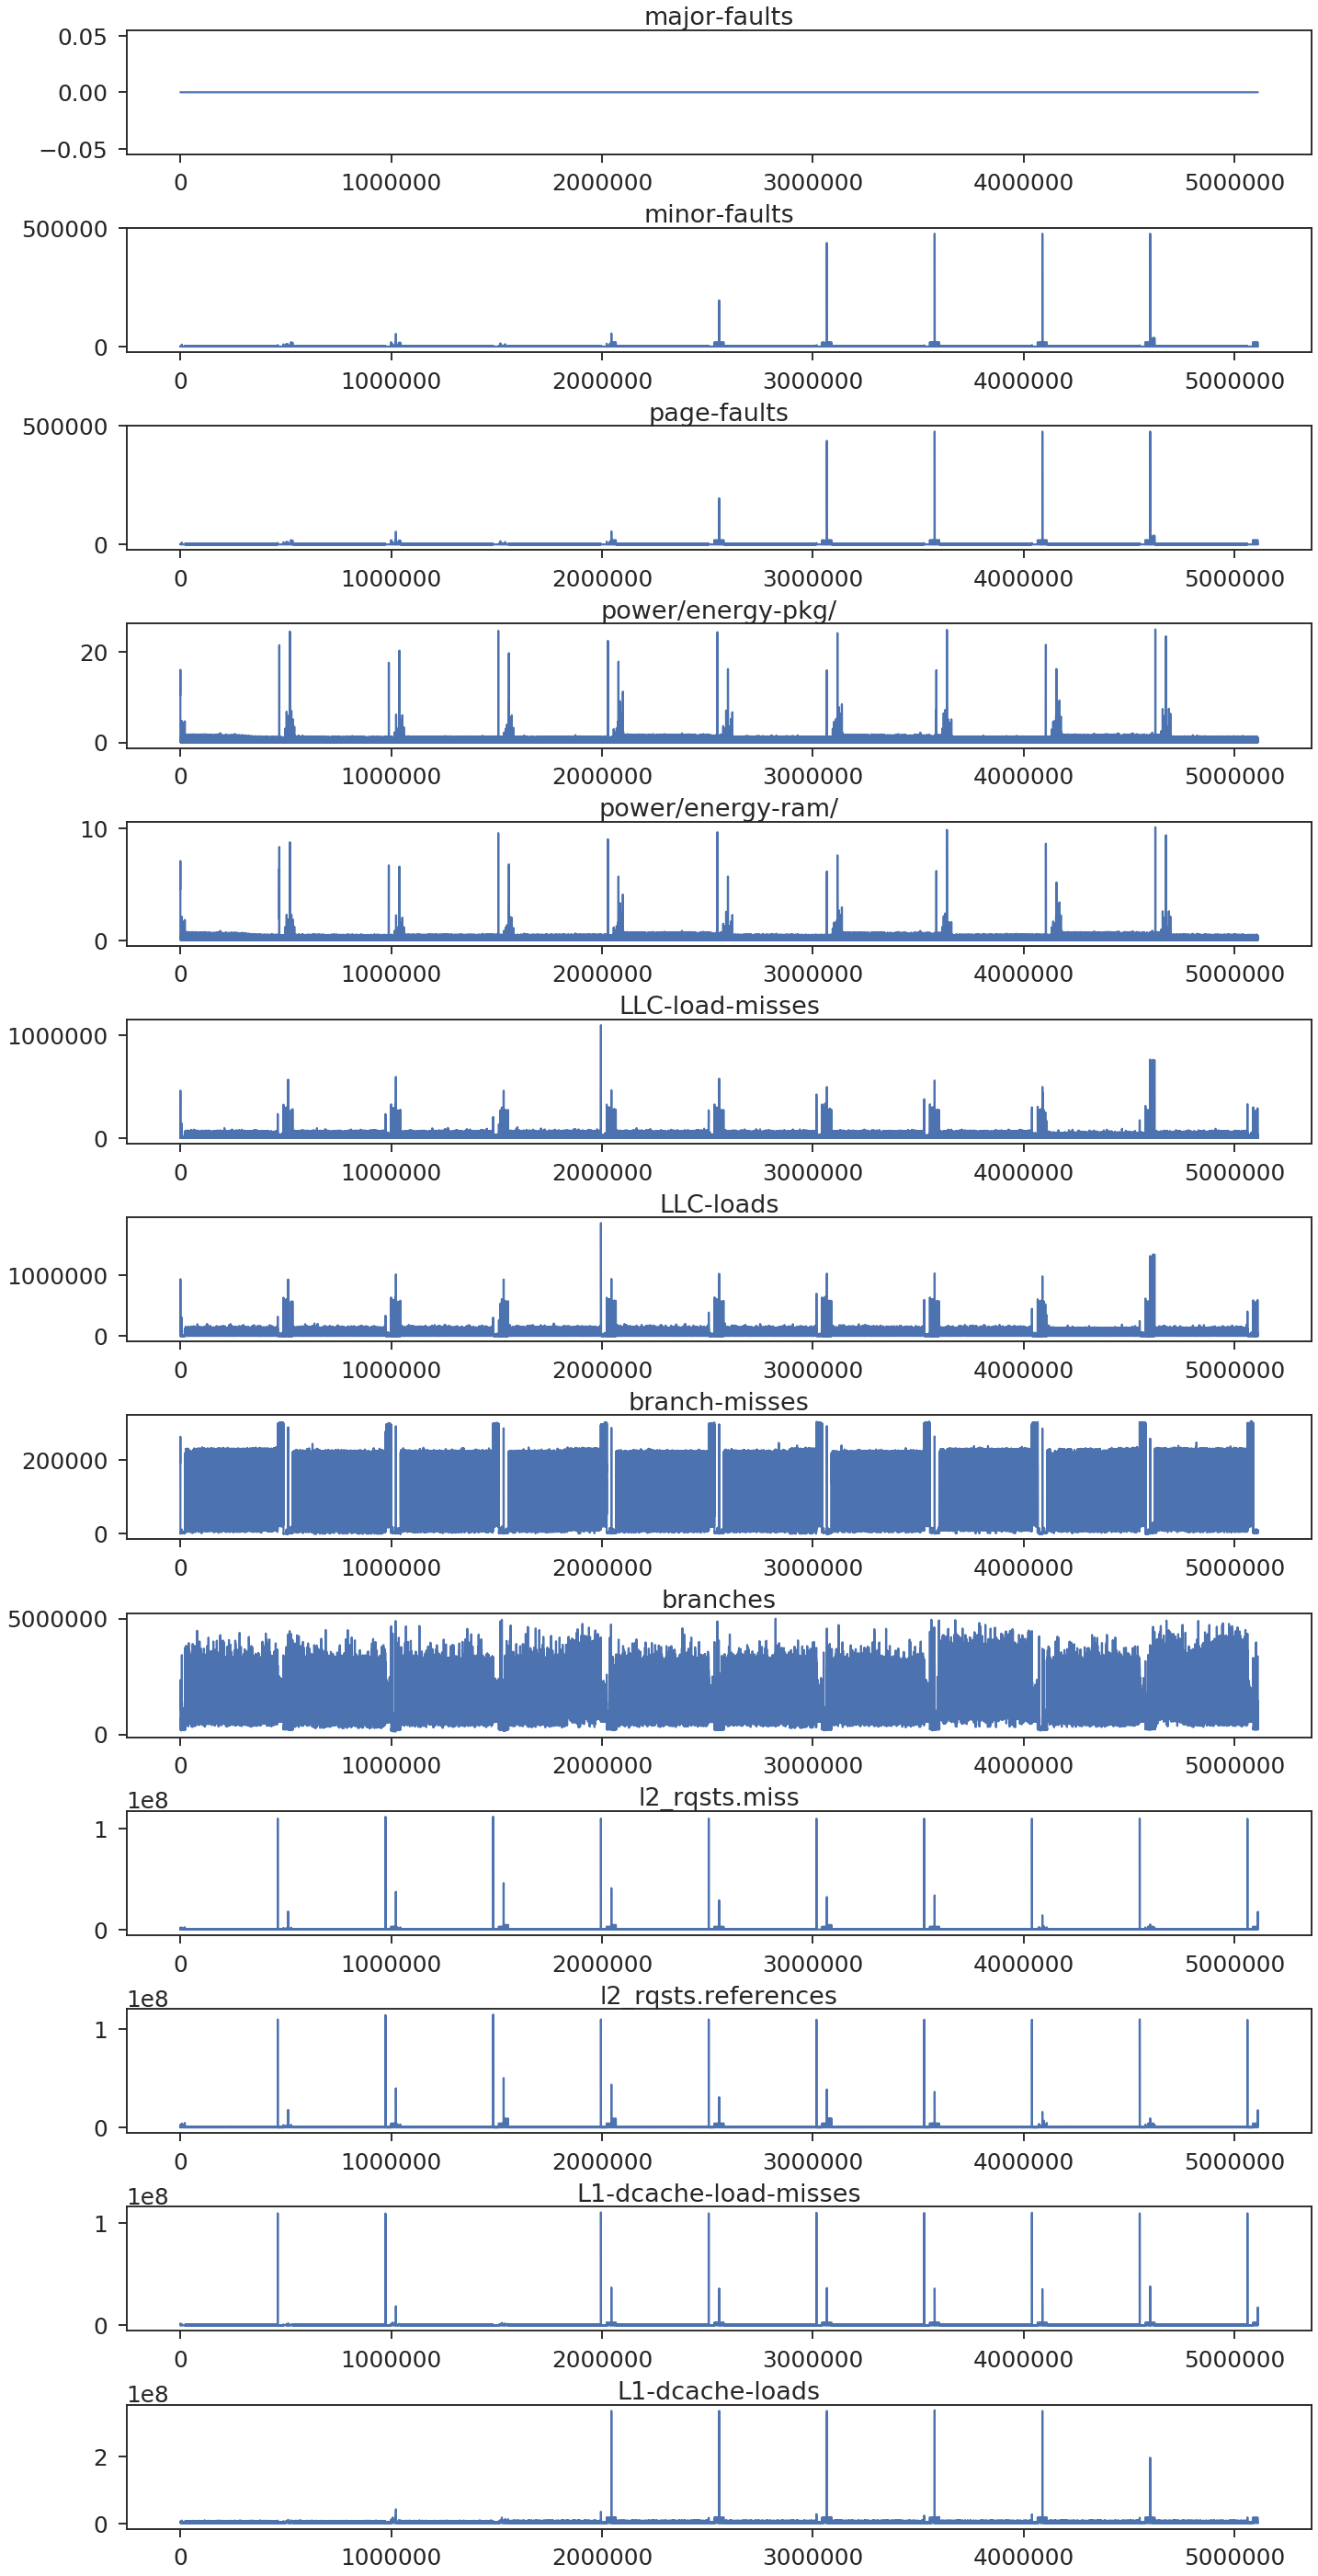

In [31]:
ncols = merged.shape[1]
fig, ax = plt.subplots()
fig.set_size_inches(20, 3 * ncols)

for i in range(ncols):
    name = merged.columns[i]
    if "instructions:" in name or "window" in name:
        continue
    plt.subplot(ncols, 1, i + 1)
    plt.plot(merged.index, merged[name])
    plt.title(name)

fig.tight_layout(pad=1.0)

In [30]:
merged

event,major-faults,minor-faults,page-faults,power/energy-pkg/,power/energy-ram/,LLC-load-misses,LLC-loads,branch-misses,branches,l2_rqsts.miss,l2_rqsts.references,L1-dcache-load-misses,L1-dcache-loads
window,,,,,,,,,,,,,
8,0.0,16.0,16.0,10.42,4.56,57.00,639.00,191022.00,1070964.00,8.223000e+03,2.774500e+04,1.312200e+04,1528599.0
9,0.0,11.0,11.0,15.91,7.09,13.00,392.00,194533.00,1126603.00,6.105000e+03,2.205300e+04,9.837000e+03,1487835.0
10,0.0,15.0,15.0,15.55,6.28,9.00,560.00,192894.00,1124285.00,4.025000e+03,1.495100e+04,1.061300e+04,1513060.0
11,0.0,15.0,15.0,0.95,0.40,3.00,472.00,192680.00,1132471.00,5.850000e+03,1.966200e+04,1.118400e+04,1494228.0
12,0.0,14.0,14.0,0.36,0.17,12.00,704.00,190964.00,1098199.00,5.061000e+03,1.600200e+04,1.575100e+04,2223495.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110350,0.0,0.0,0.0,0.10,0.03,132.00,177.00,3625.00,231202.00,1.457620e+07,1.464008e+07,1.457444e+07,1403625.5
5110352,0.0,0.0,0.0,0.10,0.03,35473.00,38712.00,9817.00,1445935.00,1.166248e+07,1.171496e+07,1.166097e+07,1472896.0
5110353,0.0,0.0,0.0,0.10,0.03,26607.25,29080.25,8277.25,1142112.25,8.748761e+06,8.789840e+06,8.747509e+06,1542166.5


## Why are phases important?

In [ ]:
scaling_data = pd.read_csv("./csv/scaling.csv")
scaling_data.Scale = scaling_data.Scale.astype(str)

In [ ]:
scaling_data

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.lineplot(data=pd.melt(scaling_data, ["Scale"], var_name="Configuration", value_name="Speed-up"), ax=ax, x="Scale",y="Speed-up", hue="Configuration", sort=False)